In [1]:
'''
Author: Alvin Thai
malaria_rates visualizes data from xmart.csv.  Spreadsheet was made by WHO with purpose
to take measures.
https://apps.who.int/gho/data/node.main.MALARIATOTALCASES?lang=en
'''
import pandas as pd
import panel as pn
pn.extension('tabulator', 'plotly')

import hvplot.pandas
import plotly.express as px

### Extract & Transform Data

In [2]:
df = pd.read_csv('xmart.csv')

In [3]:
df.head()

,Country,Total number of malaria cases (presumed + confirmed cases); 2020,Total number of malaria cases (presumed + confirmed cases); 2019,Total number of malaria cases (presumed + confirmed cases); 2018,Total number of malaria cases (presumed + confirmed cases); 2017,Total number of malaria cases (presumed + confirmed cases); 2016,Total number of malaria cases (presumed + confirmed cases); 2015,Total number of malaria cases (presumed + confirmed cases); 2014,Total number of malaria cases (presumed + confirmed cases); 2013,Total number of malaria cases (presumed + confirmed cases); 2012,Total number of malaria cases (presumed + confirmed cases); 2011,Total number of malaria cases (presumed + confirmed cases); 2010
0,Afghanistan,105 445,174 894,299 863,413 536,436 017,383 008,317 608,326 593,391 365,482 748,392 864
1,Algeria,2 726,1 014,1 242,453,432,747,266,603,887,191,408
2,Angola,7 156 110,7 530 788,5 928 260,4 500 221,4 301 146,3 254 270,3 180 021,3 144 100,3 031 546,3 501 953,3 687 574
3,Argentina,0,0,23,18,7,11,15,11,16,28,109
4,Armenia,3,NaN,6,2,2,2,1,0,4,NaN,1


In [4]:
headers = ['Country'] + list(map(str, range(2020, 2009, -1)))
df.columns = headers

for year in list(map(str, range(2020, 2009, -1))):
    df[year] = df[year].fillna(0).apply(str).apply(lambda e : "".join(e.split()))

df[['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']] = df[['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']].astype(int)
df = df[df.columns[::-1]] 
df = df.set_index('Country')

In [5]:
df.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,
Afghanistan,392864,482748,391365,326593,317608,383008,436017,413536,299863,174894,105445
Algeria,408,191,887,603,266,747,432,453,1242,1014,2726
Angola,3687574,3501953,3031546,3144100,3180021,3254270,4301146,4500221,5928260,7530788,7156110
Argentina,109,28,16,11,15,11,7,18,23,0,0
Armenia,1,0,4,0,1,2,2,2,6,0,3


### Linear Regression

In [6]:
from sklearn.model_selection import train_test_split
X = df.columns.astype(int).to_frame()
y = df.loc['Viet Nam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [7]:
from sklearn.linear_model import LinearRegression
lm= LinearRegression()
lm.fit(X_train, y_train) 

LinearRegression()

In [8]:
print(lm.intercept_)
print(lm.coef_)
predictions = lm.predict(X_test)

12211064.52631579
[-6049.44976077]


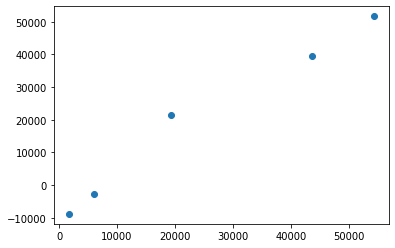

In [9]:
# verifies accuracy of predictions by linear nature
import matplotlib.pyplot as plt
import numpy as np
plt.scatter(y_test, predictions)

In [10]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print("MSE:", metrics.mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(metrics.mean_absolute_error(y_test, predictions)))

MAE: 5652.334928229451
MSE: 43402349.40478164
RMSE: 75.18201199907762


### Build Dashboard Parts

In [11]:
year_slider = pn.widgets.IntSlider(name='Year Slider', start=2010, end=2020, step=1, value=2010, bar_color='#0000ff')

In [12]:
df = df.unstack().to_frame()

In [13]:
df.reset_index(inplace=True)
df.rename(columns = {0: 'Count', 'level_0':'Year'}, inplace=True)
df

,Year,Country,Count
0,2010,Afghanistan,392864
1,2010,Algeria,408
2,2010,Angola,3687574
3,2010,Argentina,109
4,2010,Armenia,1
...,...,...,...
1095,2020,Venezuela (Bolivarian Republic of),273126
1096,2020,Viet Nam,1733
1097,2020,Yemen,164066
1098,2020,Zambia,8698304


In [14]:
@pn.depends(year_slider)
def update_area(year_slider):
    count_df = df[df['Year'] <= int(year_slider)]
    fig = px.area(count_df, x='Year', y='Count', color='Country', title='Annual Malaria Contractions until ' + str(year_slider), markers=True) 
    area_plot = pn.pane.Plotly(fig)
    return area_plot

In [15]:
idf = df.interactive()
idf.Year = idf.Year.astype(int)

pipeline = (
    idf[
        (idf.Year == year_slider) &
        (idf.Country.isin(df['Country']))
    ]
)

rate_table = pipeline.pipe(pn.widgets.Tabulator, pagination='remote', page_size=10, sizing_mode='stretch_width')
rate_table

In [16]:
df.Year = df.Year.astype(int)
df.head()

,Year,Country,Count
0,2010,Afghanistan,392864
1,2010,Algeria,408
2,2010,Angola,3687574
3,2010,Argentina,109
4,2010,Armenia,1


In [17]:
@pn.depends(year_slider)
def update_map(year_slider):
    map_df = df[df['Year'] == int(year_slider)]
    fig = px.choropleth(map_df, locations='Country', hover_name='Country', locationmode='country names', projection='equirectangular', title="Annual Malaria Cases " + str(year_slider), color='Count')
    map_plot = pn.pane.Plotly(fig)
    return map_plot    

### Plug parts into dashboard

In [18]:
template = pn.template.FastListTemplate(
    title="Dashboard of Malaria Count", 
    sidebar=[pn.pane.Markdown("# Annual Presumed and Confirmed Cases of Malaria by Country"),
             pn.pane.Markdown("#### Increasing malaria rates fly under the scope of many countries due \
             to little benefit for people in getting involved.  Responsibility falls to undeserved \
             communities and research scientists, but many refrain from speaking under their governments."),
             pn.pane.PNG('mosquito.png', sizing_mode='scale_both'),
             year_slider],
    sidebar_footer='https://www.who.int/data/gho/data/indicators/indicator-details/GHO/total-number-of-malaria-cases-presumed-confirmed-cases',
    main=[pn.Row(update_map, rate_table), pn.Row(update_area)]
)
template.servable();